In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet, Lasso, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report

In [2]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
#Ignore annoying warning (from sklearn and seaborn)


In [26]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

Note that the data is not very clean ... much of the following data cleaning came from "https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough." Essentially we make sure that pverty levels within households are equivalent.

In [27]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.
There are 0 households where the family members do not all have the same target.


Text(0.5,1,'Variables Correlated With Poverty Level')

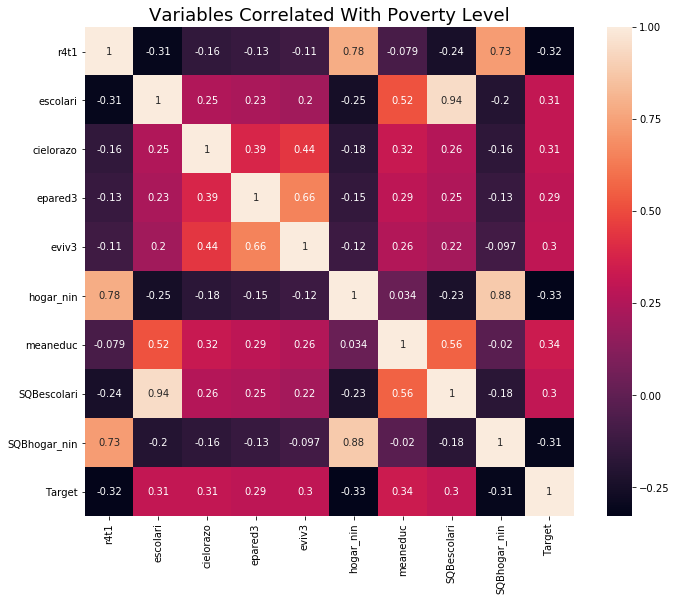

In [28]:
#Take a look at the variables that are most highly correlated with Poverty Score
corr_train = train.corr()
#This is where you can specifiy what correlation you want to display
highest_corr = corr_train.index[abs(corr_train["Target"])>0.29]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train[highest_corr].corr(), square = True, annot = True)
plt.title('Variables Correlated With Poverty Level', fontsize=18)
#Thanks Conner for this code!

In [29]:
ntrain = train.shape[0]
ntest = test.shape[0]
#Keep track of how many observarions were in 'test' and 'train'
#target_train = train.Target.values
target_train = np.array(list(train[train['Target'].notnull()]['Target'].astype(np.uint8)))
#Copy the 'Target' vector
id_train = train.Id.values
id_test = test.Id.values
alldata = pd.concat((train, test), sort = False).reset_index(drop=True)
#Put all our data together, and drop the 'Target' variable. We only want variables that can predict 'Target'
alldata.drop(['Target', 'Id'], axis=1, inplace=True)

Next we'll clean up missing values:

In [30]:
#Create a table showing missing data
total = alldata.isnull().sum().sort_values(ascending=False)
percent = (alldata.isnull().sum()/alldata.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
meaneduc,36,0.001077
SQBmeaned,36,0.001077
v14a,0,0.000000
sanitario6,0,0.000000
techocane,0,0.000000
techootro,0,0.000000
cielorazo,0,0.000000


In [31]:
for columns in ('v18q1','rez_esc', 'v2a1', 'meaneduc', 'SQBmeaned'):
    alldata[columns] = alldata[columns].fillna(0)

In [32]:
alldata.loc[alldata['rez_esc'] > 5, 'rez_esc'] = 5

In [33]:
alldata.columns[alldata.isnull().any()]

Index([], dtype='object')

In [34]:
alldata = pd.get_dummies(alldata)

In [35]:
train = alldata[:ntrain]
test = alldata[ntrain:]

In [23]:
target_train = pd.get_dummies(target_train)
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

## Random Forest

In [46]:
X_train, X_test, y_train, y_test = train_test_split(train, target_train, test_size=0.2, random_state=42)
#Split up my train data into more test and training data. I chose a test size of 0.2.

In [54]:
param_dist = {"n_estimators": [100], "max_depth": [1, 15, 20], "min_samples_split": [10, 20, 30], "max_features": [10, 25, 40],
               "min_impurity_decrease": [.1, .2, .5], "max_leaf_nodes": [10, 25, 40], 
               "bootstrap": ['True']}

#Again, testing different hyperparameters. We will be testing different amounts of depths, impurities (similar to the cost function),
#features, and nodes.
rfregressor = RandomForestClassifier()
rfgridsearch = GridSearchCV(rfregressor, param_grid=param_dist, scoring=scorer, n_jobs=-1)
rfgridsearch.fit(X_train,y_train)
best_params=rfgridsearch.best_params_

In [57]:
print(best_params)

{'bootstrap': 'True', 'max_depth': 1, 'max_features': 10, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.1, 'min_samples_split': 10, 'n_estimators': 100}


Here we determined which parameters best fit our data, below we will apply it to our set:

In [73]:
rf1reg = RandomForestClassifier(n_estimators = best_params['n_estimators'], max_depth = best_params['max_depth'], min_samples_split= best_params['min_samples_split'],
                              max_features= best_params['max_features'], min_impurity_decrease = best_params['min_impurity_decrease'],
                              max_leaf_nodes = best_params['max_leaf_nodes'], bootstrap = best_params['bootstrap'], n_jobs=-1)

rf1reg.fit(X_train, y_train)

RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=1, max_features=10, max_leaf_nodes=10,
            min_impurity_decrease=0.1, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Below is a practise random forest done with cross validation. We expect our model to be more efficient as we tested more hyperparameters.

In [52]:
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')
model = RandomForestClassifier(n_estimators= 100, random_state=10, 
                               n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, train, target_train, cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.308 with std = 0.0442


## Elastic Net

Below is Elastic net code I ran previously. As it was taking too long to complie, I only include the code here for the regression and the accomponying learning curves.

In [ ]:
clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Train MSE: {}".format(np.sqrt(mean_squared_error(y_train, train_predictions))))
print("Test MSE: {}".format(np.sqrt(mean_squared_error(y_test, test_predictions))))

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
plot_learning_curve(clf, "Learning Curve", X_train, y_train, cv=5)

In [67]:
results = rf1reg.predict(test)
sub = pd.DataFrame()
sub['Id'] = id_test
sub['Target'] = results
sub.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


In [68]:
sub.to_csv('submission.csv',index=False)

In [ ]:
##Submission